In [1]:
# Import necessary libraries
import torch.cuda as torch_cuda
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import numpy as np

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [2]:
print('===VERIFY GPU===')
print('CUDA IS AVAILABLE:', torch_cuda.is_available())
print('DEVICE COUNT:', torch_cuda.device_count())
print('DEVICE NAME:', torch_cuda.get_device_name(0))

# If CUDA is available, print GPU details
if torch.cuda.is_available():
    print(f"Number of GPUs: {torch_cuda.device_count()}")
    print(f"GPU Name: {torch_cuda.get_device_name(0)}")
    print(f"GPU Memory Allocated: {torch_cuda.memory_allocated(0)} bytes")
    print(f"GPU Memory Cached: {torch_cuda.memory_reserved(0)} bytes")

# Select device: GPU if available, otherwise CPU
device = torch.device('cuda:0' if torch_cuda.is_available() else 'cpu')

===VERIFY GPU===
CUDA IS AVAILABLE: True
DEVICE COUNT: 1
DEVICE NAME: NVIDIA RTX A4000
Number of GPUs: 1
GPU Name: NVIDIA RTX A4000
GPU Memory Allocated: 0 bytes
GPU Memory Cached: 0 bytes


## Dataset

In [3]:
# Define hyperparameters
batch_size = 32

# Define transformations: Convert to tensor and normalize
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

svhn_trainset = datasets.SVHN(
    root='../Data/SVHN',
    split='train',
    download=True,
    transform=transformations
)

svhn_testset = datasets.SVHN(
    root='../Data/SVHN',
    split='test',
    download=True,
    transform=transformations
)

trainloader = DataLoader(
    svhn_trainset,
    batch_size=batch_size,
    shuffle=True
)

testloader = DataLoader(
    svhn_testset,
    batch_size=batch_size,
    shuffle=False,
)

In [4]:
trainloader.dataset.data[0].shape

(3, 32, 32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


TRAIN SET LENGTH: 26032
TEST SET LENGTH: 26032


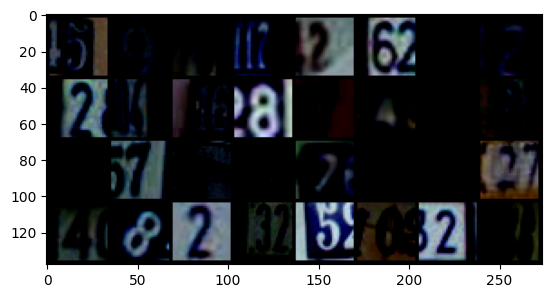

In [5]:
print('TRAIN SET LENGTH:', len(svhn_testset))
print('TEST SET LENGTH:', len(svhn_testset))

def imshow(img):

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='viridis')
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(make_grid(images))

## Model

### Parameters

In [6]:
learning_rate = 0.01
learning_decay = 10**-9
epochs = 100

# Classes for MNIST digits
classes = (0,1,2,3,4,5,6,7,8,9)

### Definition

In [7]:
# Define a multi-layer perceptron (MLP) mode

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1) 
        self.pool1 = nn.MaxPool2d(kernel_size=2) 
        self.dropout1 = nn.Dropout(0.25) 

        # Second convolutional block
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)  
        self.pool2 = nn.MaxPool2d(kernel_size=2)  
        self.dropout2 = nn.Dropout(0.25)  

        # Fully connected layers
        self.fc1 = nn.Linear(4096, 4096)  
        self.dropout3 = nn.Dropout(0.5) 
        self.fc2 = nn.Linear(4096, 512)
        self.out = nn.Linear(512, 10) 

    def forward(self, x, output = 3):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = x.view(-1, 4096)

        x = F.relu(self.fc1(x))
        if output == 1:
            return x
        x = self.dropout3(x)
        
        x = F.relu(self.fc2(x))
        if output == 2:
            return x

        x = self.out(x) 
        return x


# Instantiate and move model to the selected device
cnn = CNN().to(device)

loss_function = nn.CrossEntropyLoss()  # CrossEntropyLoss expects raw logits
optimizer = optim.SGD(cnn.parameters(), lr=learning_rate,
                    weight_decay=learning_decay)


def train(epoch):

    cnn.train()
    for batch_idx, (data, target) in enumerate(trainloader):

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        output = cnn(data, output=3)

        loss = loss_function(output, target)

        loss.backward()

        optimizer.step()

        if batch_idx % 25 == 0:
            print('Train Epoch: {:>3}\t[{:>5}/{:>5} ({:>3.0f}%)]\tLoss: {:>7.6f}'.format(
                epoch + 1, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))


def test():
    cnn.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in testloader:

            data, target = data.to(device), target.to(device)

            output = cnn(data, output=3)

            test_loss += loss_function(output, target).item()

            pred = output.argmax(dim=1, keepdim=True)

            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testloader)

    print('\nTest set: Average loss: {:>10.4f}, Accuracy: {:>5}/{:>5} ({:>3.3f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))


for epoch in range(epochs):
    train(epoch)
    test()

Train Epoch:   1	[    0/73257 (  0%)]	Loss: 2.302658
Train Epoch:   1	[  800/73257 (  1%)]	Loss: 2.302633
Train Epoch:   1	[ 1600/73257 (  2%)]	Loss: 2.291872
Train Epoch:   1	[ 2400/73257 (  3%)]	Loss: 2.299054
Train Epoch:   1	[ 3200/73257 (  4%)]	Loss: 2.281632
Train Epoch:   1	[ 4000/73257 (  5%)]	Loss: 2.304124
Train Epoch:   1	[ 4800/73257 (  7%)]	Loss: 2.292962
Train Epoch:   1	[ 5600/73257 (  8%)]	Loss: 2.279317
Train Epoch:   1	[ 6400/73257 (  9%)]	Loss: 2.279817
Train Epoch:   1	[ 7200/73257 ( 10%)]	Loss: 2.272571
Train Epoch:   1	[ 8000/73257 ( 11%)]	Loss: 2.260172
Train Epoch:   1	[ 8800/73257 ( 12%)]	Loss: 2.296703
Train Epoch:   1	[ 9600/73257 ( 13%)]	Loss: 2.335787
Train Epoch:   1	[10400/73257 ( 14%)]	Loss: 2.313285
Train Epoch:   1	[11200/73257 ( 15%)]	Loss: 2.273315
Train Epoch:   1	[12000/73257 ( 16%)]	Loss: 2.266260
Train Epoch:   1	[12800/73257 ( 17%)]	Loss: 2.270392
Train Epoch:   1	[13600/73257 ( 19%)]	Loss: 2.271915
Train Epoch:   1	[14400/73257 ( 20%)]	Loss: 2.

In [8]:
torch.save(cnn.state_dict(), '../Saved/SVHN_CNN_TRAINED.pt')